In [1]:
# %%
from gpytorch.kernels.periodic_kernel import PeriodicKernel
from gpytorch.likelihoods import (
    GaussianLikelihood, 
    FixedNoiseGaussianLikelihood,
)
from gpytorch.means import (
    ZeroMean, 
    ConstantMean, 
    LinearMean,
)
# http://www.gaussianprocess.org/gpml/chapters/RW4.pdf
# https://www.cs.toronto.edu/~duvenaud/cookbook/
from gpytorch.kernels import (
    RBFKernel,
    RQKernel,  
    MaternKernel,
    SpectralMixtureKernel,
    AdditiveKernel,
    PolynomialKernel,
    ScaleKernel,
    ProductKernel,
    LinearKernel
)

import torch
import gpytorch
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from torch.nn.modules.loss import SoftMarginLoss

from data import (
    get_silso_data, 
    centre_x, 
    split_train_test, 
    to_tensor, 
    sample_random, sample_interval, sample_meaninterval, 
    plot_data,
)
from models import GP, train, data_loglik, calc_BIC
from utility import (
    spectral_density, 
    get_peaks, 
    plot_losses, 
    plot_density, 
    plot_kernel, 
    plot_transform, 
)
from transforms import (
    identity, 
    log_transform, exp_transform, 
    invsoftplus_transform, softplus_transform, 
    power_transform, 
    TanhWarp, LogWarp, 
)

In [2]:
# %% data
data = get_silso_data('SN_m_tot_V2.0')
data = centre_x(data)

sampling_interval = 4  # months
f_s = 12 / sampling_interval
sampledata_int = sample_interval(data, sampling_interval)
sampledata_mean = sample_meaninterval(data, sampling_interval, ['year_frac', 'ssn_total'])
# sampledata_mean['year_frac'] += sampling_interval / 12 / 2
sampledata = sampledata_mean

min_train_year = 1848  # 1900
min_test_year = 2010  # 1979  # 2018
traindata, testdata = split_train_test(sampledata, min_test_year=min_test_year, min_train_year=min_train_year, year_col='year_frac')

train_x, train_y = to_tensor(traindata['year_frac']), to_tensor(traindata['ssn_total'])
test_x, test_y = to_tensor(testdata['year_frac']), to_tensor(testdata['ssn_total'])

history_x = torch.cat([train_x, test_x])
future_x = torch.tensor([2022 + sampling_interval * 1/12*(i+1) for i in range(11*12//sampling_interval)])
all_x = torch.cat([history_x, future_x])

../data/SILSO data/SN_m_tot_V2.0.csv


In [3]:
# %% transforms
p = 1/2
pt = power_transform(p)
ipt = power_transform(1/p)
input_transform = lambda x: log_transform(pt(x))
output_transform = lambda x: ipt(exp_transform(x))
input_transform = pt
output_transform = ipt

transf_train_y = input_transform(train_y)
transf_train_y = input_transform(train_y)
transf_test_y = input_transform(test_y)

assert torch.allclose(train_y, output_transform(transf_train_y))
# plot_transform(train_y, input_transform)

# kernels

In [15]:
# %% define kernels
base_kernels = []
base_kernel_names = []

def create_smk(num_mixtures):
    def _create_smk(x, y):
        smk = SpectralMixtureKernel(num_mixtures)
        smk.initialize_from_data_empspect(x, y)
        return smk
    return _create_smk

for num_mixtures in [1, 2, 4, 6, 8, 10]:
    base_kernels.append(create_smk(num_mixtures))
    base_kernel_names.append(f'smk_{num_mixtures}')

base_kernels.append(lambda x,y: ScaleKernel(PeriodicKernel()))
base_kernel_names.append('periodic')
base_kernels.append(lambda x,y: ScaleKernel(RBFKernel()))
base_kernel_names.append('rbf')
base_kernels.append(lambda x,y: ScaleKernel(RQKernel()))
base_kernel_names.append('rq')
# this creates a lot of PSD errors...
# base_kernels.append(lambda x,y: ScaleKernel(LinearKernel()))
# base_kernel_names.append('linear')

def create_matern(nu):
    def _create_matern(x, y):
        return ScaleKernel(MaternKernel(nu))
    return _create_matern 

for nu in [0.5, 1.5, 2.5]:
    base_kernels.append(create_matern(nu))
    base_kernel_names.append(f'matern_{nu}')

base_compositions = [AdditiveKernel, ProductKernel]
base_composition_names = ['+', '*']

# functions

In [35]:
def fit_model(x, y, kernel, training_iter = 2000, seed=0):
    mean = ConstantMean(prior=gpytorch.priors.NormalPrior(y.mean(), y.std()))
    noise_prior = gpytorch.priors.GammaPrior(1.05, 0.05)
    noise_prior_mode = (noise_prior.concentration - 1) / noise_prior.rate
    lik = GaussianLikelihood(
        noise_prior=noise_prior,
        noise_constraint=gpytorch.constraints.constraints.GreaterThan(
            1e-6,
            transform=None,
            initial_value=noise_prior_mode,
        ),
    )

    model = GP(mean, kernel(x, y), x, y, likelihood=lik, warp=None)
    torch.manual_seed(seed)
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.05)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    train(model, optimizer, mll, train_x, transf_train_y, training_iter)
    torch.save(model.state_dict(), f'./models/search/gp_{hash(model)}.model')
    return model

def fit_model_repeat(x, y, kernel, repeats, training_iter=2000, criteria=calc_BIC, seed=0):
    torch.manual_seed(seed)
    best_criteria = None
    best_model = None
    for _ in range(repeats):
        model = fit_model(x, y, kernel, seed=torch.random.seed(), training_iter=training_iter)
        c = criteria(model, x, y)
        if not best_criteria or c < best_criteria:
            best_criteria = c 
            best_model = model 
    return best_model, best_criteria

def create_composite_kernel(c, k1, k2):
    def _create_composite_kernel(x, y):
        return c(k1(x, y), k2(x, y))
    return _create_composite_kernel

def kernel_search(x, y, base_kernels, base_kernel_names, base_compositions, base_composition_names, max_depth, 
                  test_x=None, test_y=None, 
                  training_iter=2000, fit_repeats=1, criteria=calc_BIC, seed=0, 
                  depth_0_kernels=None, depth_0_kernel_names=None, early_abort=True, 
                 ):
    kernel_cache = dict()
    bic_cache = dict()
    best_bic = np.inf
    best_kernel = None
    best_kernel_name = ''
    print('[INFO] beginning base kernel search')
    if depth_0_kernels is None or depth_0_kernel_names is None: 
        depth_0_kernels = base_kernels
        depth_0_kernel_names = base_kernel_names
    for k, kernel in zip(depth_0_kernel_names, depth_0_kernels): 
        model, bic = fit_model_repeat(x, y, kernel, fit_repeats, training_iter=training_iter, criteria=criteria, seed=seed)
        if test_x is not None and test_y is not None:
            model.eval()
            bic = calc_BIC(model, test_x, test_y)
        kernel_cache.setdefault(0, dict())[k] = kernel
        bic_cache.setdefault(0, dict())[k] = bic
        if bic < best_bic: 
            best_bic = bic
            best_kernel = kernel
            best_kernel_name = k
    print(f'''[INFO] finished base kernel search
        best BIC: {best_bic}
        best kernel: {best_kernel_name}
    ''')

    for depth in range(max_depth):
        print(f'[INFO] beginning composite kernel search, depth={depth}')
        best_kernel_name, best_bic = min(bic_cache[depth].items(), key=lambda kv: kv[1])
        best_kernel = kernel_cache[depth][best_kernel_name]
        new_best_bic = np.inf
        new_best_kernel = None
        new_best_kernel_name = ''
        for c, comp in zip(base_composition_names, base_compositions):
            for k, new_kernel in zip(base_kernel_names, base_kernels):
                kernel = create_composite_kernel(comp, best_kernel, new_kernel)
                model, bic = fit_model_repeat(x, y, kernel, fit_repeats, training_iter=training_iter, criteria=criteria, seed=seed)
                if test_x is not None and test_y is not None:
                    model.eval()
                    bic = calc_BIC(model, test_x, test_y)
                kc = '('+best_kernel_name+c+k+')'
                kernel_cache.setdefault(depth+1, dict())[kc] = kernel
                bic_cache.setdefault(depth+1, dict())[kc] = bic
                if bic < new_best_bic:
                    new_best_bic = bic
                    new_best_kernel = kernel
                    new_best_kernel_name = kc
        print(f'''[INFO] finished composite kernel search, depth={depth}
            best BIC: {new_best_bic}
            best kernel: {new_best_kernel_name}
        ''')
        if early_abort and new_best_bic > best_bic: 
            print(f'[INFO] could not find a better composite kernel at depth {depth}; aborting')
            break
    
    return kernel_cache, bic_cache

## testing

In [6]:
model = fit_model(train_x, transf_train_y, base_kernels[1], training_iter=10)

Epoch: 100%|██████████| 10/10 [00:00<00:00, 38.09it/s, loss=7.38]


In [7]:
model, bic = fit_model_repeat(train_x, transf_train_y, base_kernels[1], 2, training_iter=10)
bic

Epoch: 100%|██████████| 10/10 [00:00<00:00, 49.58it/s, loss=7.92]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 10/10 [00:00<00:00, 30.60it/s, loss=8.95]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


3727.568770553704

## only need one smk kernel

In [9]:
gpytorch.settings.debug(False)  # not implemented? https://docs.gpytorch.ai/en/stable/_modules/gpytorch/settings.html#debug

In [55]:
%%time
kernel_cache, bic_cache = kernel_search(train_x, transf_train_y, 
                                        base_kernels[:6], base_kernel_names[:6],
                                        base_compositions, base_composition_names, 
                                        -1, 
                                        criteria=lambda model,x,y: -data_loglik(model, x, y), 
                                            test_x = test_x, test_y = transf_test_y, 
                                        fit_repeats=5, training_iter=1000)

[INFO] beginning base kernel search


Epoch: 100%|██████████| 1000/1000 [00:20<00:00, 48.68it/s, loss=2.11]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:18<00:00, 54.08it/s, loss=1.72]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:17<00:00, 55.89it/s, loss=1.64]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch:  92%|█████████▏| 917/1000 [00:17<00:01, 42.88it/s, loss=1.73]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To cha

[INFO] finished base kernel search
        best BIC: 135.12962306526606
        best kernel: smk_2
    
CPU times: user 2h 41min 49s, sys: 4min 40s, total: 2h 46min 30s
Wall time: 11min 29s


In [56]:
bic_cache

{0: {'smk_1': 157.78517892079617,
  'smk_2': 135.12962306526606,
  'smk_4': 152.32508789229178,
  'smk_6': 172.4700384981261,
  'smk_8': 196.6759479662651,
  'smk_10': 215.2836594973924}}

# kernel search

In [11]:
x, y = train_x, transf_train_y

## se, per, rq; BIC

In [10]:
%%time
kernel_cache, bic_cache = kernel_search(train_x, transf_train_y, 
                                        base_kernels[6:9], base_kernel_names[6:9],
                                        base_compositions, base_composition_names, 
                                        2, criteria=calc_BIC, 
                                            test_x = test_x, test_y = transf_test_y, 
                                        fit_repeats=5, training_iter=1000)

[INFO] beginning base kernel search


Epoch: 100%|██████████| 1000/1000 [00:17<00:00, 57.24it/s, loss=1.67]


[INFO] finished base kernel search
        best BIC: 119.71098310245725
        best kernel: rbf
    
[INFO] beginning composite kernel search, depth=0


Epoch: 100%|██████████| 1000/1000 [00:35<00:00, 28.57it/s, loss=1.66]


[INFO] finished composite kernel search, depth=0
            best BIC: 125.62561009069759
            best kernel: (rbf*rbf)
        
[INFO] could not find a better composite kernel at depth 0; aborting
CPU times: user 4h 24min 33s, sys: 4min 23s, total: 4h 28min 57s
Wall time: 18min 59s


In [14]:
bic_cache

{0: {'periodic': 222.22507455067898,
  'rbf': 119.71098310245725,
  'rq': 123.48397042470242},
 1: {'(rbf+periodic)': 130.2598645027865,
  '(rbf+rbf)': 125.63204929968197,
  '(rbf+rq)': 128.9951855477084,
  '(rbf*periodic)': 137.9683071907748,
  '(rbf*rbf)': 125.62561009069759,
  '(rbf*rq)': 129.25489776694667}}

Epoch: 100%|██████████| 2000/2000 [00:58<00:00, 34.22it/s, loss=1.63]


BIC 1182.16
train log-likelihood: -572.52
BIC 125.42
test log-likelihood: -51.96


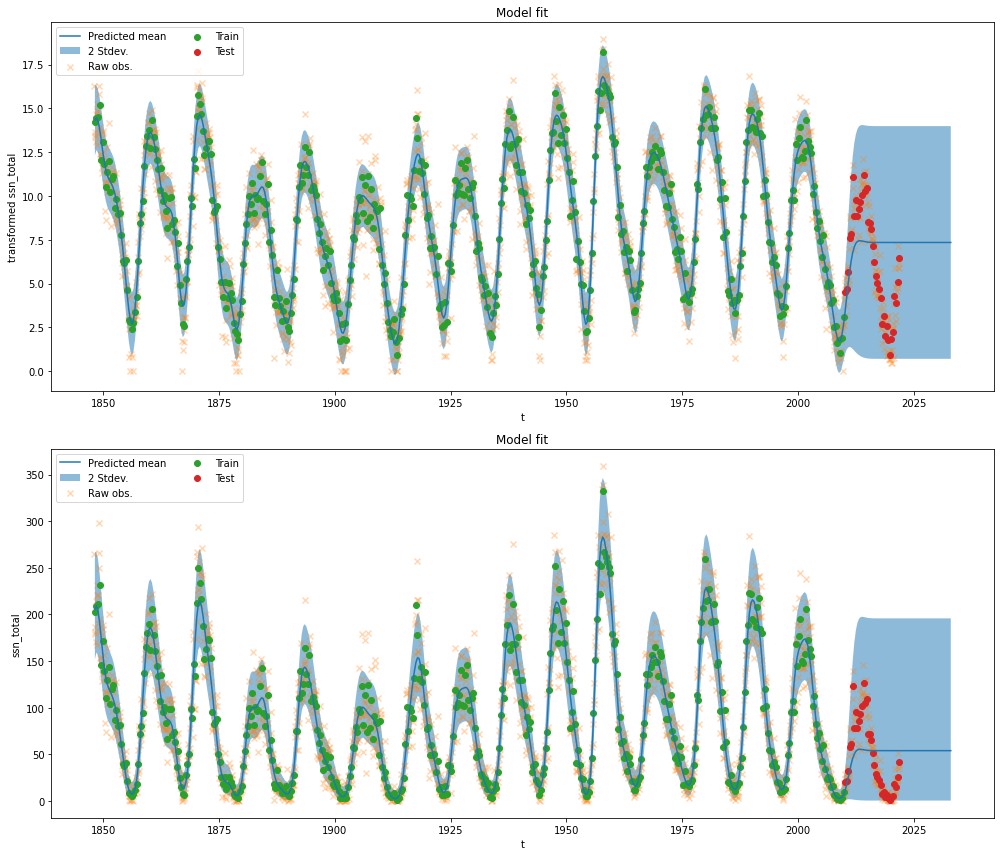

In [12]:
# %% analysis
depth = max(bic_cache.keys())
kname, score = min(bic_cache[depth].items(), key=lambda kv: kv[1])
k = kernel_cache[depth][kname]

model = fit_model(x, y, k, training_iter = 2000)
def plot_model_fit(model, figsize=(14, 12), transform=identity):
    pred, lower, upper = model.predict(all_x)

    if transform == identity: 
        ts = [(transform, 'ssn_total'), ]
        nplots = 1
    else:
        ts = [(identity, 'transformed ssn_total'), (transform, 'ssn_total')]
        nplots = 2
    fig, ax = plt.subplots(nplots, 1, figsize=figsize)
    for i,(t,ylbl) in enumerate(ts): 
        ax_t = ax[i]
        ax_t.set_title('Model fit')
        ax_t.set_xlabel('t')
        ax_t.set_ylabel(ylbl)
        ax_t.plot(all_x, t(pred.mean).numpy().flatten(), label='Predicted mean')
        ax_t.fill_between(all_x, t(lower).numpy(), t(upper).numpy(), alpha=0.5, label='2 Stdev.')
        data_ = data.loc[data.year_frac > min_train_year]
        ax_t.scatter(data_.year_frac, t(input_transform(data_.ssn_total)), label='Raw obs.', marker='x', alpha=0.3)
        ax_t.scatter(train_x, t(transf_train_y), label='Train')
        ax_t.scatter(test_x, t(transf_test_y), label='Test')
        ax_t.legend(loc='upper left', ncol=2)

    fig.tight_layout()
    return fig, ax

model.train()
print(f'BIC {calc_BIC(model, train_x, transf_train_y):.2f}')
print(f'train log-likelihood: {data_loglik(model, train_x, transf_train_y):.2f}')
model.eval()
print(f'BIC {calc_BIC(model, test_x, transf_test_y):.2f}')
print(f'test log-likelihood: {data_loglik(model, test_x, transf_test_y):.2f}')
fig, ax = plot_model_fit(model, transform=output_transform)

## se, per, rq; loglikelihood

In [23]:
%%time
kernel_cache, bic_cache = kernel_search(train_x, transf_train_y, 
                                        base_kernels[6:9], base_kernel_names[6:9],
                                        base_compositions, base_composition_names, 
                                        2, criteria=lambda model,x,y: -data_loglik(model, x, y), 
                                            test_x = test_x, test_y = transf_test_y, 
                                        fit_repeats=5, training_iter=1000)

[INFO] beginning base kernel search


Epoch: 100%|██████████| 1000/1000 [00:13<00:00, 71.68it/s, loss=2.91]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:17<00:00, 57.77it/s, loss=1.67]


[INFO] finished base kernel search
        best BIC: 119.71098310245725
        best kernel: rbf
    
[INFO] beginning composite kernel search, depth=0


Epoch: 100%|██████████| 1000/1000 [00:34<00:00, 28.77it/s, loss=1.66]


[INFO] finished composite kernel search, depth=0
            best BIC: 125.62561009069759
            best kernel: (rbf*rbf)
        
[INFO] could not find a better composite kernel at depth 0; aborting
CPU times: user 4h 21min 32s, sys: 3min 59s, total: 4h 25min 31s
Wall time: 18min 45s


In [24]:
bic_cache

{0: {'periodic': 222.22507455067898,
  'rbf': 119.71098310245725,
  'rq': 123.48397042470242},
 1: {'(rbf+periodic)': 130.2598645027865,
  '(rbf+rbf)': 125.63204929968197,
  '(rbf+rq)': 128.9951855477084,
  '(rbf*periodic)': 137.9683071907748,
  '(rbf*rbf)': 125.62561009069759,
  '(rbf*rq)': 129.25489776694667}}

Epoch: 100%|██████████| 2000/2000 [00:57<00:00, 34.83it/s, loss=1.63]


BIC 1182.16
train log-likelihood: -572.52
BIC 125.42
test log-likelihood: -51.96


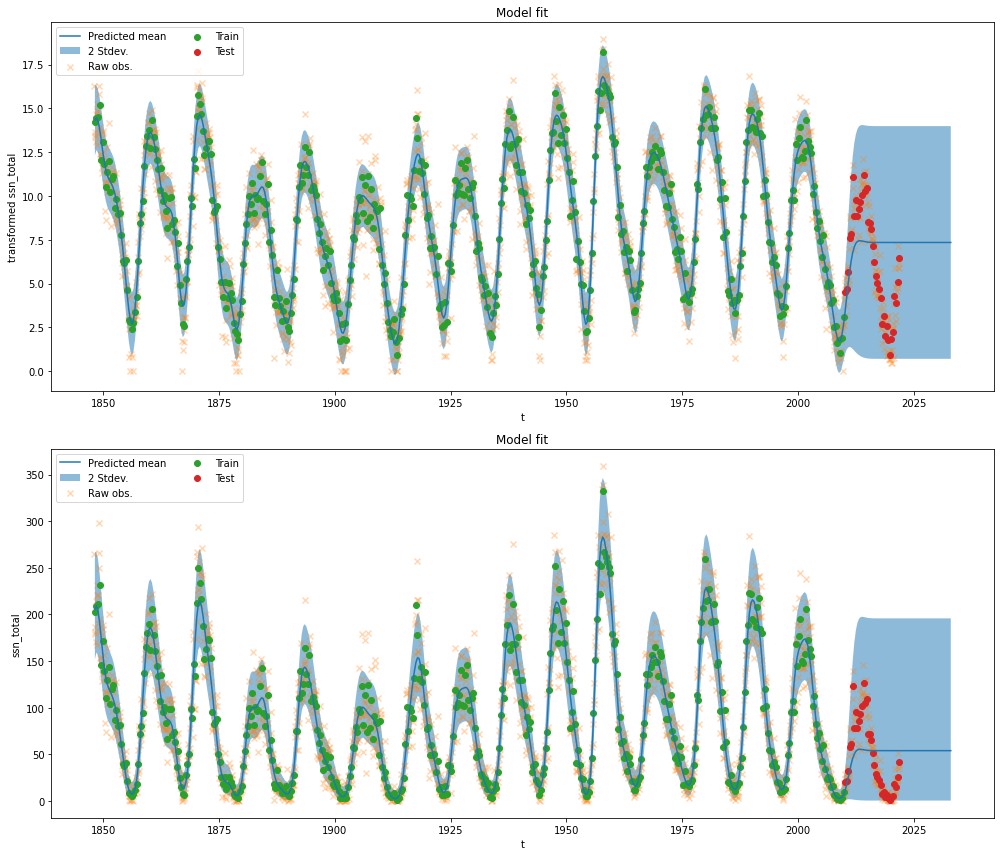

In [25]:
# %% analysis
depth = max(bic_cache.keys())
kname, score = min(bic_cache[depth].items(), key=lambda kv: kv[1])
k = kernel_cache[depth][kname]

model = fit_model(x, y, k, training_iter = 2000)
def plot_model_fit(model, figsize=(14, 12), transform=identity):
    pred, lower, upper = model.predict(all_x)

    if transform == identity: 
        ts = [(transform, 'ssn_total'), ]
        nplots = 1
    else:
        ts = [(identity, 'transformed ssn_total'), (transform, 'ssn_total')]
        nplots = 2
    fig, ax = plt.subplots(nplots, 1, figsize=figsize)
    for i,(t,ylbl) in enumerate(ts): 
        ax_t = ax[i]
        ax_t.set_title('Model fit')
        ax_t.set_xlabel('t')
        ax_t.set_ylabel(ylbl)
        ax_t.plot(all_x, t(pred.mean).numpy().flatten(), label='Predicted mean')
        ax_t.fill_between(all_x, t(lower).numpy(), t(upper).numpy(), alpha=0.5, label='2 Stdev.')
        data_ = data.loc[data.year_frac > min_train_year]
        ax_t.scatter(data_.year_frac, t(input_transform(data_.ssn_total)), label='Raw obs.', marker='x', alpha=0.3)
        ax_t.scatter(train_x, t(transf_train_y), label='Train')
        ax_t.scatter(test_x, t(transf_test_y), label='Test')
        ax_t.legend(loc='upper left', ncol=2)

    fig.tight_layout()
    return fig, ax

model.train()
print(f'BIC {calc_BIC(model, train_x, transf_train_y):.2f}')
print(f'train log-likelihood: {data_loglik(model, train_x, transf_train_y):.2f}')
model.eval()
print(f'BIC {calc_BIC(model, test_x, transf_test_y):.2f}')
print(f'test log-likelihood: {data_loglik(model, test_x, transf_test_y):.2f}')
fig, ax = plot_model_fit(model, transform=output_transform)

## search with smk as base, BIC as criteria

In [36]:
base_kernels2 = base_kernels[6:9] + [base_kernels[-1]]
base_kernel_names2 = base_kernel_names[6:9] + [base_kernel_names[-1]]
base_kernel_names2

['periodic', 'rbf', 'rq', 'matern_2.5']

In [38]:
%%time
kernel_cache, bic_cache = kernel_search(train_x, transf_train_y, 
                                        base_kernels2, base_kernel_names2,
                                        base_compositions, base_composition_names, 
                                        2, criteria=calc_BIC, 
                                            test_x = test_x, test_y = transf_test_y, 
                                        fit_repeats=5, training_iter=1000, 
                                        depth_0_kernels=base_kernels[3:6], depth_0_kernel_names=base_kernel_names[3:6], 
                                        early_abort=False, 
                                       )

[INFO] beginning base kernel search


Epoch: 100%|██████████| 1000/1000 [00:18<00:00, 52.73it/s, loss=1.64]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:19<00:00, 52.31it/s, loss=1.58]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:19<00:00, 51.06it/s, loss=1.58]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:20<00:00, 48.43it/s, loss=1.55]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training d

[INFO] finished base kernel search
        best BIC: 175.41946324177843
        best kernel: smk_6
    
[INFO] beginning composite kernel search, depth=0


Epoch: 100%|██████████| 1000/1000 [00:23<00:00, 42.41it/s, loss=1.58]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:22<00:00, 43.83it/s, loss=1.63]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:21<00:00, 46.60it/s, loss=1.6]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:21<00:00, 47.45it/s, loss=1.63]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training da

Epoch: 100%|██████████| 1000/1000 [00:24<00:00, 40.93it/s, loss=1.57]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:21<00:00, 45.63it/s, loss=1.56]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:25<00:00, 39.63it/s, loss=1.56]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:22<00:00, 44.64it/s, loss=1.57]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training d

[INFO] finished composite kernel search, depth=0
            best BIC: 178.33530326027176
            best kernel: (smk_6*rq)
        
[INFO] beginning composite kernel search, depth=1


Epoch: 100%|██████████| 1000/1000 [00:26<00:00, 37.32it/s, loss=1.58]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:25<00:00, 38.83it/s, loss=1.58]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:25<00:00, 38.89it/s, loss=1.58]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [01:44<00:00,  9.61it/s, loss=1.58]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training d

Epoch: 100%|██████████| 1000/1000 [00:28<00:00, 34.56it/s, loss=1.6]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:29<00:00, 34.30it/s, loss=1.6]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:29<00:00, 34.19it/s, loss=1.6]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:28<00:00, 34.91it/s, loss=1.6]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data.

[INFO] finished composite kernel search, depth=1
            best BIC: 186.52023206735979
            best kernel: ((smk_6*rq)+rbf)
        
CPU times: user 10h 55min 37s, sys: 5min 27s, total: 11h 1min 5s
Wall time: 48min 36s


In [39]:
bic_cache

{0: {'smk_6': 175.41946324177843,
  'smk_8': 193.8290241381401,
  'smk_10': 213.6609330569627},
 1: {'(smk_6+periodic)': 186.02355094093582,
  '(smk_6+rbf)': 185.65157222464768,
  '(smk_6+rq)': 182.22521872658035,
  '(smk_6+matern_2.5)': 179.24831294730393,
  '(smk_6*periodic)': 196.0955190195491,
  '(smk_6*rbf)': 183.96332454398362,
  '(smk_6*rq)': 178.33530326027176,
  '(smk_6*matern_2.5)': 184.32112788871018},
 2: {'((smk_6*rq)+periodic)': 198.39715463130418,
  '((smk_6*rq)+rbf)': 186.52023206735979,
  '((smk_6*rq)+rq)': 189.08123666255418,
  '((smk_6*rq)+matern_2.5)': 186.62229047800432,
  '((smk_6*rq)*periodic)': 193.71213418452683,
  '((smk_6*rq)*rbf)': 196.25982557321916,
  '((smk_6*rq)*rq)': 190.72051888911668,
  '((smk_6*rq)*matern_2.5)': 195.67123304392229}}

Epoch: 100%|██████████| 2000/2000 [00:51<00:00, 38.52it/s, loss=1.55]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 2000/2000 [03:59<00:00,  8.34it/s, loss=1.55]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 2000/2000 [04:09<00:00,  8.01it/s, loss=1.55]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 2000/2000 [04:08<00:00,  8.04it/s, loss=1.55]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training d

BIC 1241.84
train log-likelihood: -543.59
BIC 185.71
test log-likelihood: -48.06


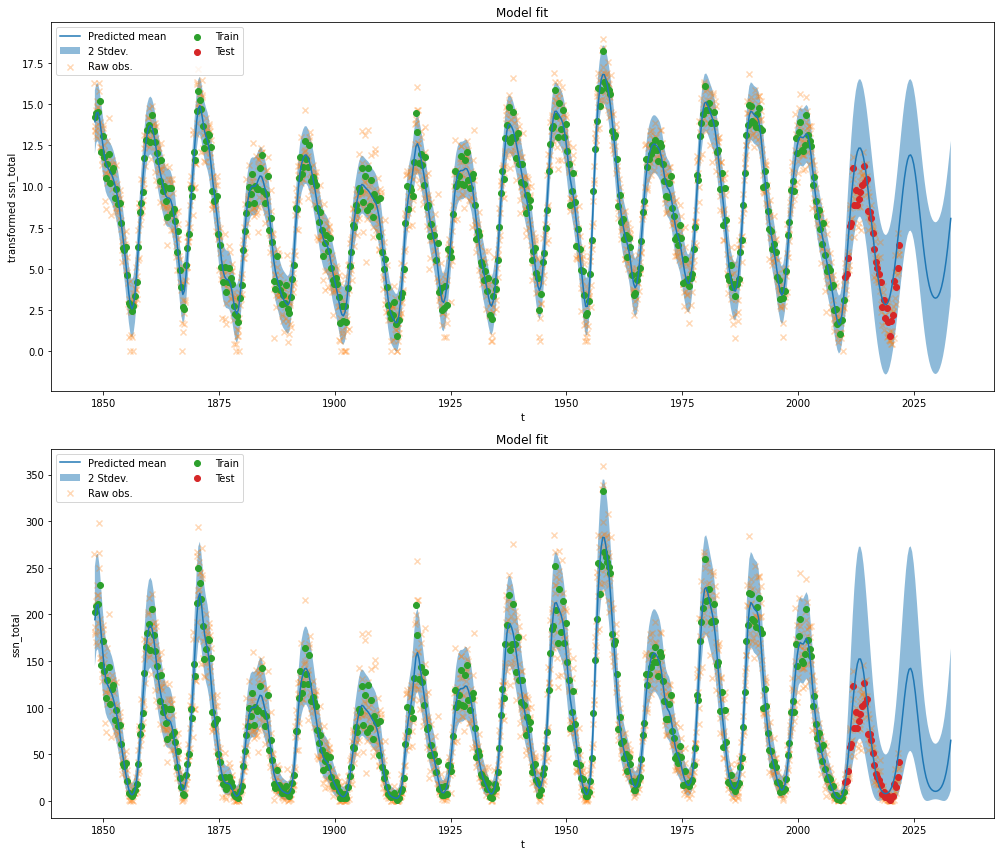

In [40]:
# %% analysis
depth = max(bic_cache.keys())
kname, score = min(bic_cache[depth].items(), key=lambda kv: kv[1])
k = kernel_cache[depth][kname]

# model = fit_model(x, y, k, training_iter = 2000)
model, _ = fit_model_repeat(x, y, k, 5, training_iter=2000, criteria=calc_BIC)
def plot_model_fit(model, figsize=(14, 12), transform=identity):
    pred, lower, upper = model.predict(all_x)

    if transform == identity: 
        ts = [(transform, 'ssn_total'), ]
        nplots = 1
    else:
        ts = [(identity, 'transformed ssn_total'), (transform, 'ssn_total')]
        nplots = 2
    fig, ax = plt.subplots(nplots, 1, figsize=figsize)
    for i,(t,ylbl) in enumerate(ts): 
        ax_t = ax[i]
        ax_t.set_title('Model fit')
        ax_t.set_xlabel('t')
        ax_t.set_ylabel(ylbl)
        ax_t.plot(all_x, t(pred.mean).numpy().flatten(), label='Predicted mean')
        ax_t.fill_between(all_x, t(lower).numpy(), t(upper).numpy(), alpha=0.5, label='2 Stdev.')
        data_ = data.loc[data.year_frac > min_train_year]
        ax_t.scatter(data_.year_frac, t(input_transform(data_.ssn_total)), label='Raw obs.', marker='x', alpha=0.3)
        ax_t.scatter(train_x, t(transf_train_y), label='Train')
        ax_t.scatter(test_x, t(transf_test_y), label='Test')
        ax_t.legend(loc='upper left', ncol=2)

    fig.tight_layout()
    return fig, ax

model.train()
print(f'BIC {calc_BIC(model, train_x, transf_train_y):.2f}')
print(f'train log-likelihood: {data_loglik(model, train_x, transf_train_y):.2f}')
model.eval()
print(f'BIC {calc_BIC(model, test_x, transf_test_y):.2f}')
print(f'test log-likelihood: {data_loglik(model, test_x, transf_test_y):.2f}')
fig, ax = plot_model_fit(model, transform=output_transform)

## search with smk as base, loglikelihood as criteria

In [32]:
%%time
kernel_cache, bic_cache = kernel_search(train_x, transf_train_y, 
                                        base_kernels2, base_kernel_names2,
                                        base_compositions, base_composition_names, 
                                        2, criteria=lambda model,x,y: -data_loglik(model, x, y), 
                                            test_x = test_x, test_y = transf_test_y, 
                                        fit_repeats=5, training_iter=1000, 
                                        depth_0_kernels=base_kernels[3:6], depth_0_kernel_names=base_kernel_names[3:6]
                                       )

[INFO] beginning base kernel search


Epoch: 100%|██████████| 1000/1000 [00:20<00:00, 49.81it/s, loss=1.63]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:19<00:00, 50.13it/s, loss=1.63]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:19<00:00, 50.35it/s, loss=1.57]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:19<00:00, 51.58it/s, loss=1.6]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training da

[INFO] finished base kernel search
        best BIC: 173.3403311617003
        best kernel: smk_6
    
[INFO] beginning composite kernel search, depth=0


Epoch: 100%|██████████| 1000/1000 [00:22<00:00, 44.65it/s, loss=1.62]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:23<00:00, 43.41it/s, loss=1.58]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:21<00:00, 46.98it/s, loss=1.57]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:21<00:00, 46.79it/s, loss=1.59]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training d

Epoch: 100%|██████████| 1000/1000 [00:23<00:00, 41.71it/s, loss=1.58]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:23<00:00, 42.97it/s, loss=1.56]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:24<00:00, 40.56it/s, loss=1.57]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
Epoch: 100%|██████████| 1000/1000 [00:22<00:00, 43.64it/s, loss=1.56]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training d

[INFO] finished composite kernel search, depth=0
            best BIC: 178.19452567238113
            best kernel: (smk_6*rq)
        
[INFO] could not find a better composite kernel at depth 0; aborting
CPU times: user 5h 28min 58s, sys: 5min 9s, total: 5h 34min 8s
Wall time: 24min 12s


In [33]:
bic_cache

{0: {'smk_6': 173.3403311617003,
  'smk_8': 195.45397836177293,
  'smk_10': 212.1778016482713},
 1: {'(smk_6+periodic)': 182.82717795509598,
  '(smk_6+rbf)': 181.81086635306565,
  '(smk_6+rq)': 182.37082572120926,
  '(smk_6+matern_2.5)': 179.7273092241594,
  '(smk_6*periodic)': 188.26940055031082,
  '(smk_6*rbf)': 184.0953969927141,
  '(smk_6*rq)': 178.19452567238113,
  '(smk_6*matern_2.5)': 184.30068111136643}}

Epoch: 100%|██████████| 2000/2000 [00:45<00:00, 44.15it/s, loss=1.55]
/home/hbl26/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


BIC 1233.30
train log-likelihood: -545.51
BIC 178.92
test log-likelihood: -48.25


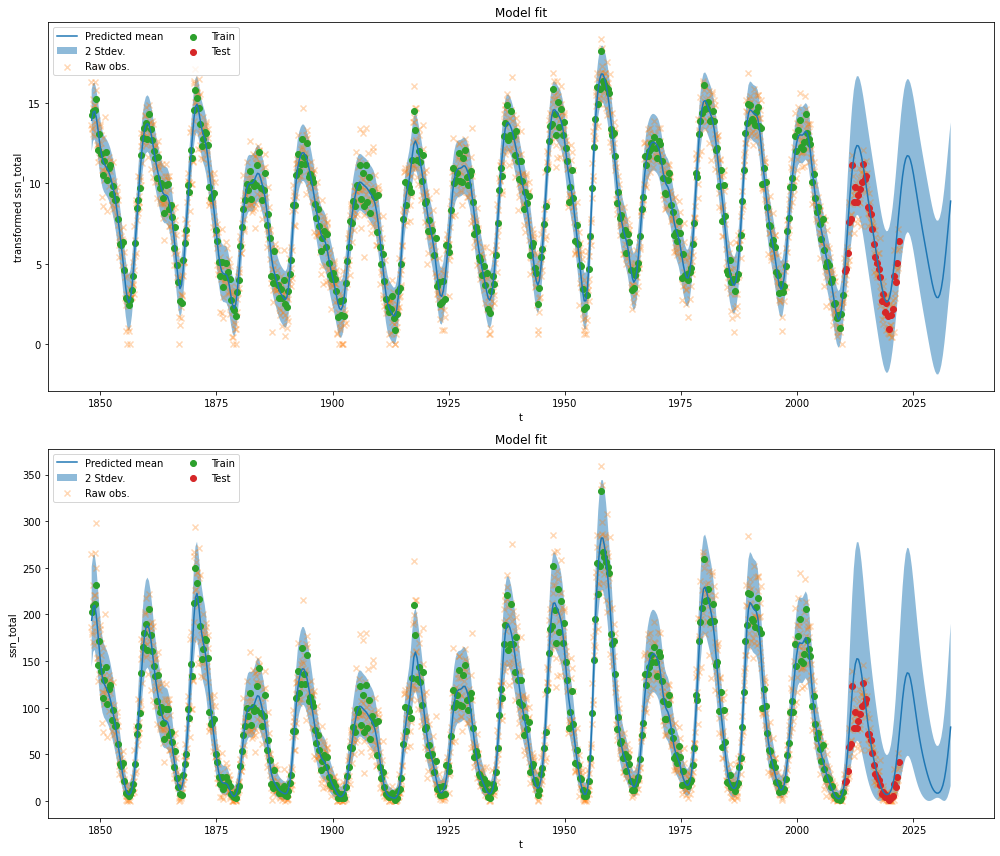

In [34]:
# %% analysis
depth = max(bic_cache.keys())
kname, score = min(bic_cache[depth].items(), key=lambda kv: kv[1])
k = kernel_cache[depth][kname]

model = fit_model(x, y, k, training_iter = 2000)
def plot_model_fit(model, figsize=(14, 12), transform=identity):
    pred, lower, upper = model.predict(all_x)

    if transform == identity: 
        ts = [(transform, 'ssn_total'), ]
        nplots = 1
    else:
        ts = [(identity, 'transformed ssn_total'), (transform, 'ssn_total')]
        nplots = 2
    fig, ax = plt.subplots(nplots, 1, figsize=figsize)
    for i,(t,ylbl) in enumerate(ts): 
        ax_t = ax[i]
        ax_t.set_title('Model fit')
        ax_t.set_xlabel('t')
        ax_t.set_ylabel(ylbl)
        ax_t.plot(all_x, t(pred.mean).numpy().flatten(), label='Predicted mean')
        ax_t.fill_between(all_x, t(lower).numpy(), t(upper).numpy(), alpha=0.5, label='2 Stdev.')
        data_ = data.loc[data.year_frac > min_train_year]
        ax_t.scatter(data_.year_frac, t(input_transform(data_.ssn_total)), label='Raw obs.', marker='x', alpha=0.3)
        ax_t.scatter(train_x, t(transf_train_y), label='Train')
        ax_t.scatter(test_x, t(transf_test_y), label='Test')
        ax_t.legend(loc='upper left', ncol=2)

    fig.tight_layout()
    return fig, ax

model.train()
print(f'BIC {calc_BIC(model, train_x, transf_train_y):.2f}')
print(f'train log-likelihood: {data_loglik(model, train_x, transf_train_y):.2f}')
model.eval()
print(f'BIC {calc_BIC(model, test_x, transf_test_y):.2f}')
print(f'test log-likelihood: {data_loglik(model, test_x, transf_test_y):.2f}')
fig, ax = plot_model_fit(model, transform=output_transform)